In [58]:
import sys
import getopt
#sys.path.insert(0, '~/nestor/')
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from numpy import linalg as LA
from scipy.spatial import distance
import numpy as np
import pandas as pd
import os                           
import math                         
from sklearn import metrics
from numpy import linalg as LA
import statistics      
from sklearn.metrics.cluster import adjusted_mutual_info_score
import warnings
warnings.filterwarnings('ignore')

def uncertainity_mean(X_train1,pred,means,covariances,weights,km,numberofdimens):
  X_train1["pred"]=pred
  meanss=means
  weiths=weights
  variances=[]
  covariancematrix=covariances
  for i in covariancematrix: #The diagonal of cov is the variance of each gmm
    diag=np.diag(i)
    variances.append(diag)
  variances=np.array(variances)
  countiterations=0
  unc=[]
  un=[]

  sep=[]
  for g in range(0,len(meanss)):  ##Frechet distance
    for t in range(0,len(meanss)):
      if (t==g):
        continue
      else:  
        sep.append(frechetDistance(meanss[t],meanss[g],covariancematrix[t],covariancematrix[g]))
  separation=np.array(sep)
  Dmin=np.array(separation).min()
  Dmax=np.array(separation).max()
  Sep=(Dmax/Dmin)*(1/separation.sum())

  for i in range(0,len(meanss)):  #Uncertainty  ##i run each cluster
    cweight=weiths[i]
    cmean=meanss[i]
    cvar=variances[i]
    lim_inf=cmean-(km*cvar)
    lim_sup=cmean+(km*cvar)
    unc=[]
    o=X_train1[X_train1["pred"]==i].iloc[:,:numberofdimens].copy()

    for j in range(len(o)): # j run each data 
      DM=distance.mahalanobis(np.array(o.iloc[j]), cmean, np.linalg.inv(covariancematrix[i]))
      varbool=(DM>=km)
      varunc=[]
      #print("varbool",varbool)
      if (varbool):
        varunc.append(2*km*DM)
      else:
        vs=((DM**2)+(km*DM)+(km**2)/2)
        varunc.append(vs)
    un.append(np.array(varunc)) 
  return np.sum(un)/Sep


def merguncertain (xtrain,y,Means,covariances,weights,numberofdimens):
  X_train11=xtrain
  X_train11["pred"]=y
  UNIndex=[]
  len(Means)
  Pairwise=np.ones((len(Means), len(Means)))
  labels=[]
  for i in range(len(Means)):
    labels.append(i)
    for j in range(len(Means)):
        if (i==j):
          continue
        Pairwise[j,i]=(frechetDistance(Means[i],Means[j],covariances[i],covariances[j]))
        

  while len(Pairwise) > 2 :
      UNIndex.append(uncertainity_mean(X_train11.iloc[:,:numberofdimens],X_train11["pred"],Means,covariances,weights,1,numberofdimens))

      Similar_clusters=np.unravel_index(Pairwise.argmin(),Pairwise.shape)  
      Similar_clusters_labels=( labels[Similar_clusters[0]],labels[Similar_clusters[1]])

      data_size_1=len(X_train11[X_train11["pred"]==Similar_clusters_labels[0]])
      data_size_2=len(X_train11[X_train11["pred"]==Similar_clusters_labels[1]])
      mean_1=Means[Similar_clusters[0]]
      mean_2=Means[Similar_clusters[1]] 
      new_mean = (data_size_1* mean_1 + data_size_2*mean_2)/(data_size_1 + data_size_2)
      Means[Similar_clusters[0]]=new_mean

      X_train11["pred"]=X_train11["pred"].replace(Similar_clusters_labels[1], Similar_clusters_labels[0])
      #print(X_train11["pred"].unique())
      NewCovariance=X_train11[X_train11["pred"]==Similar_clusters_labels[0]].iloc[:,:numberofdimens].cov()
      covariances[Similar_clusters[0]]=NewCovariance
      weights[Similar_clusters[0]]=weights[Similar_clusters[0]]+weights[Similar_clusters[1]]

      updpairwisecolum=[]
      for j in range(0,len(Means)):
          updpairwisecolum.append((frechetDistance(Means[Similar_clusters[0]],Means[j],covariances[Similar_clusters[0]],covariances[j])))
      #print(updpairwisecolum)    
      Pairwise[:,Similar_clusters[0]]=updpairwisecolum
      Pairwise[Similar_clusters[0],:]=updpairwisecolum

      Means= np.delete(Means, (Similar_clusters[1]), axis=0)
      weights= np.delete(weights, (Similar_clusters[1]), axis=0)
      covariances=np.delete(covariances, (Similar_clusters[1]), axis=0)
      labels.remove(Similar_clusters_labels[1])
      Pairwise= np.delete(Pairwise, (Similar_clusters[1]), axis=0)
      Pairwise= np.delete(Pairwise, (Similar_clusters[1]), axis=1)
      np.fill_diagonal(Pairwise, 1)
  return UNIndex

def frechetDistance(u1,u2,E1,E2): 
  return (LA.norm(np.absolute(u1-u2)**2))+np.trace(E1+E2-(2*(E1*E2)**(0.5)))

def genData(n_samples,n_featuress, n_components,cl_std,randomstate):
  X, y_true = make_blobs(
        n_samples, n_features, centers=n_components, cluster_std=cl_std, random_state=randomstate
    )
  X = X[:, ::-1]
  dataFrame=pd.DataFrame(X)
  dataFrame["y"]=y_true
  return dataFrame

def UW_index(X,lim):
  cpred=[]
  admis=[]
  
  dataFrame= pd.DataFrame(X).round(4)
  dim=dataFrame.shape[1]
  kgmm=lim 

  X_train111=dataFrame
  GM = GaussianMixture(n_components=kgmm, covariance_type="full",random_state=1).fit(X_train111)
  X_train111["pred"]=GM.predict(X_train111)
  Means=GM.means_
  covariances=GM.covariances_
  weights=GM.weights_
  y=X_train111["pred"]
      
  index=merguncertain (dataFrame,y,Means,covariances,weights,dim)
  index.reverse()
  change=pd.DataFrame(index,columns=["a"])
  recomended=change["a"].argmin()+2
  print('number of recommended clusters',recomended)
  return recomended

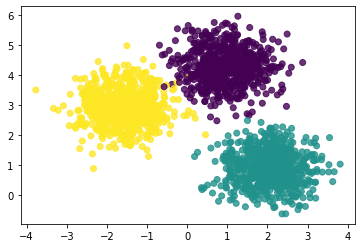

In [64]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
X, y = make_blobs(n_samples=2000, centers=3, n_features=2, cluster_std=0.6,
               random_state=0)
plt.scatter(X[:,0],X[:,1],c=y,alpha=0.8)
ax = plt.axes()
 
# Setting the background color of the plot
# using set_facecolor() method
ax.set_facecolor("White")

As input arguments UW_index receive:

X: array samples vs Dimensions 
lim: A high number of clusters. For example if you thing that there is an amount 'y' of clusters then lim at least  lim= y+10

In [68]:
Recomended_Clusters=UW_index(X,20)

number of recommended clusters 3
